# Just Tweaking with Pretrained Vision Transformer Models

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00


In [2]:
#Now importing vision transformer base model
from transformers import ViTModel
import torch
import torch.nn as nn

In [3]:
#Now load a pretrained vision transformer model
checkpoint='google/vit-base-patch16-224-in21k'
model=ViTModel.from_pretrained(checkpoint,add_pooling_layer=False)

input_img=torch.randn(16,3,224,224)

output_embedding=model(input_img)
#print(output_embedding)
print(f"Output embedding size: {output_embedding['last_hidden_state'].size()}")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Output embedding size: torch.Size([16, 197, 768])


In [4]:
num_labels=136
hidden_size=768
classifier=nn.Linear(hidden_size,num_labels)
output_classification=classifier(output_embedding['last_hidden_state'][:,0,:])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([16, 136])


# Now Running the main task of Facial Keypoint Detection
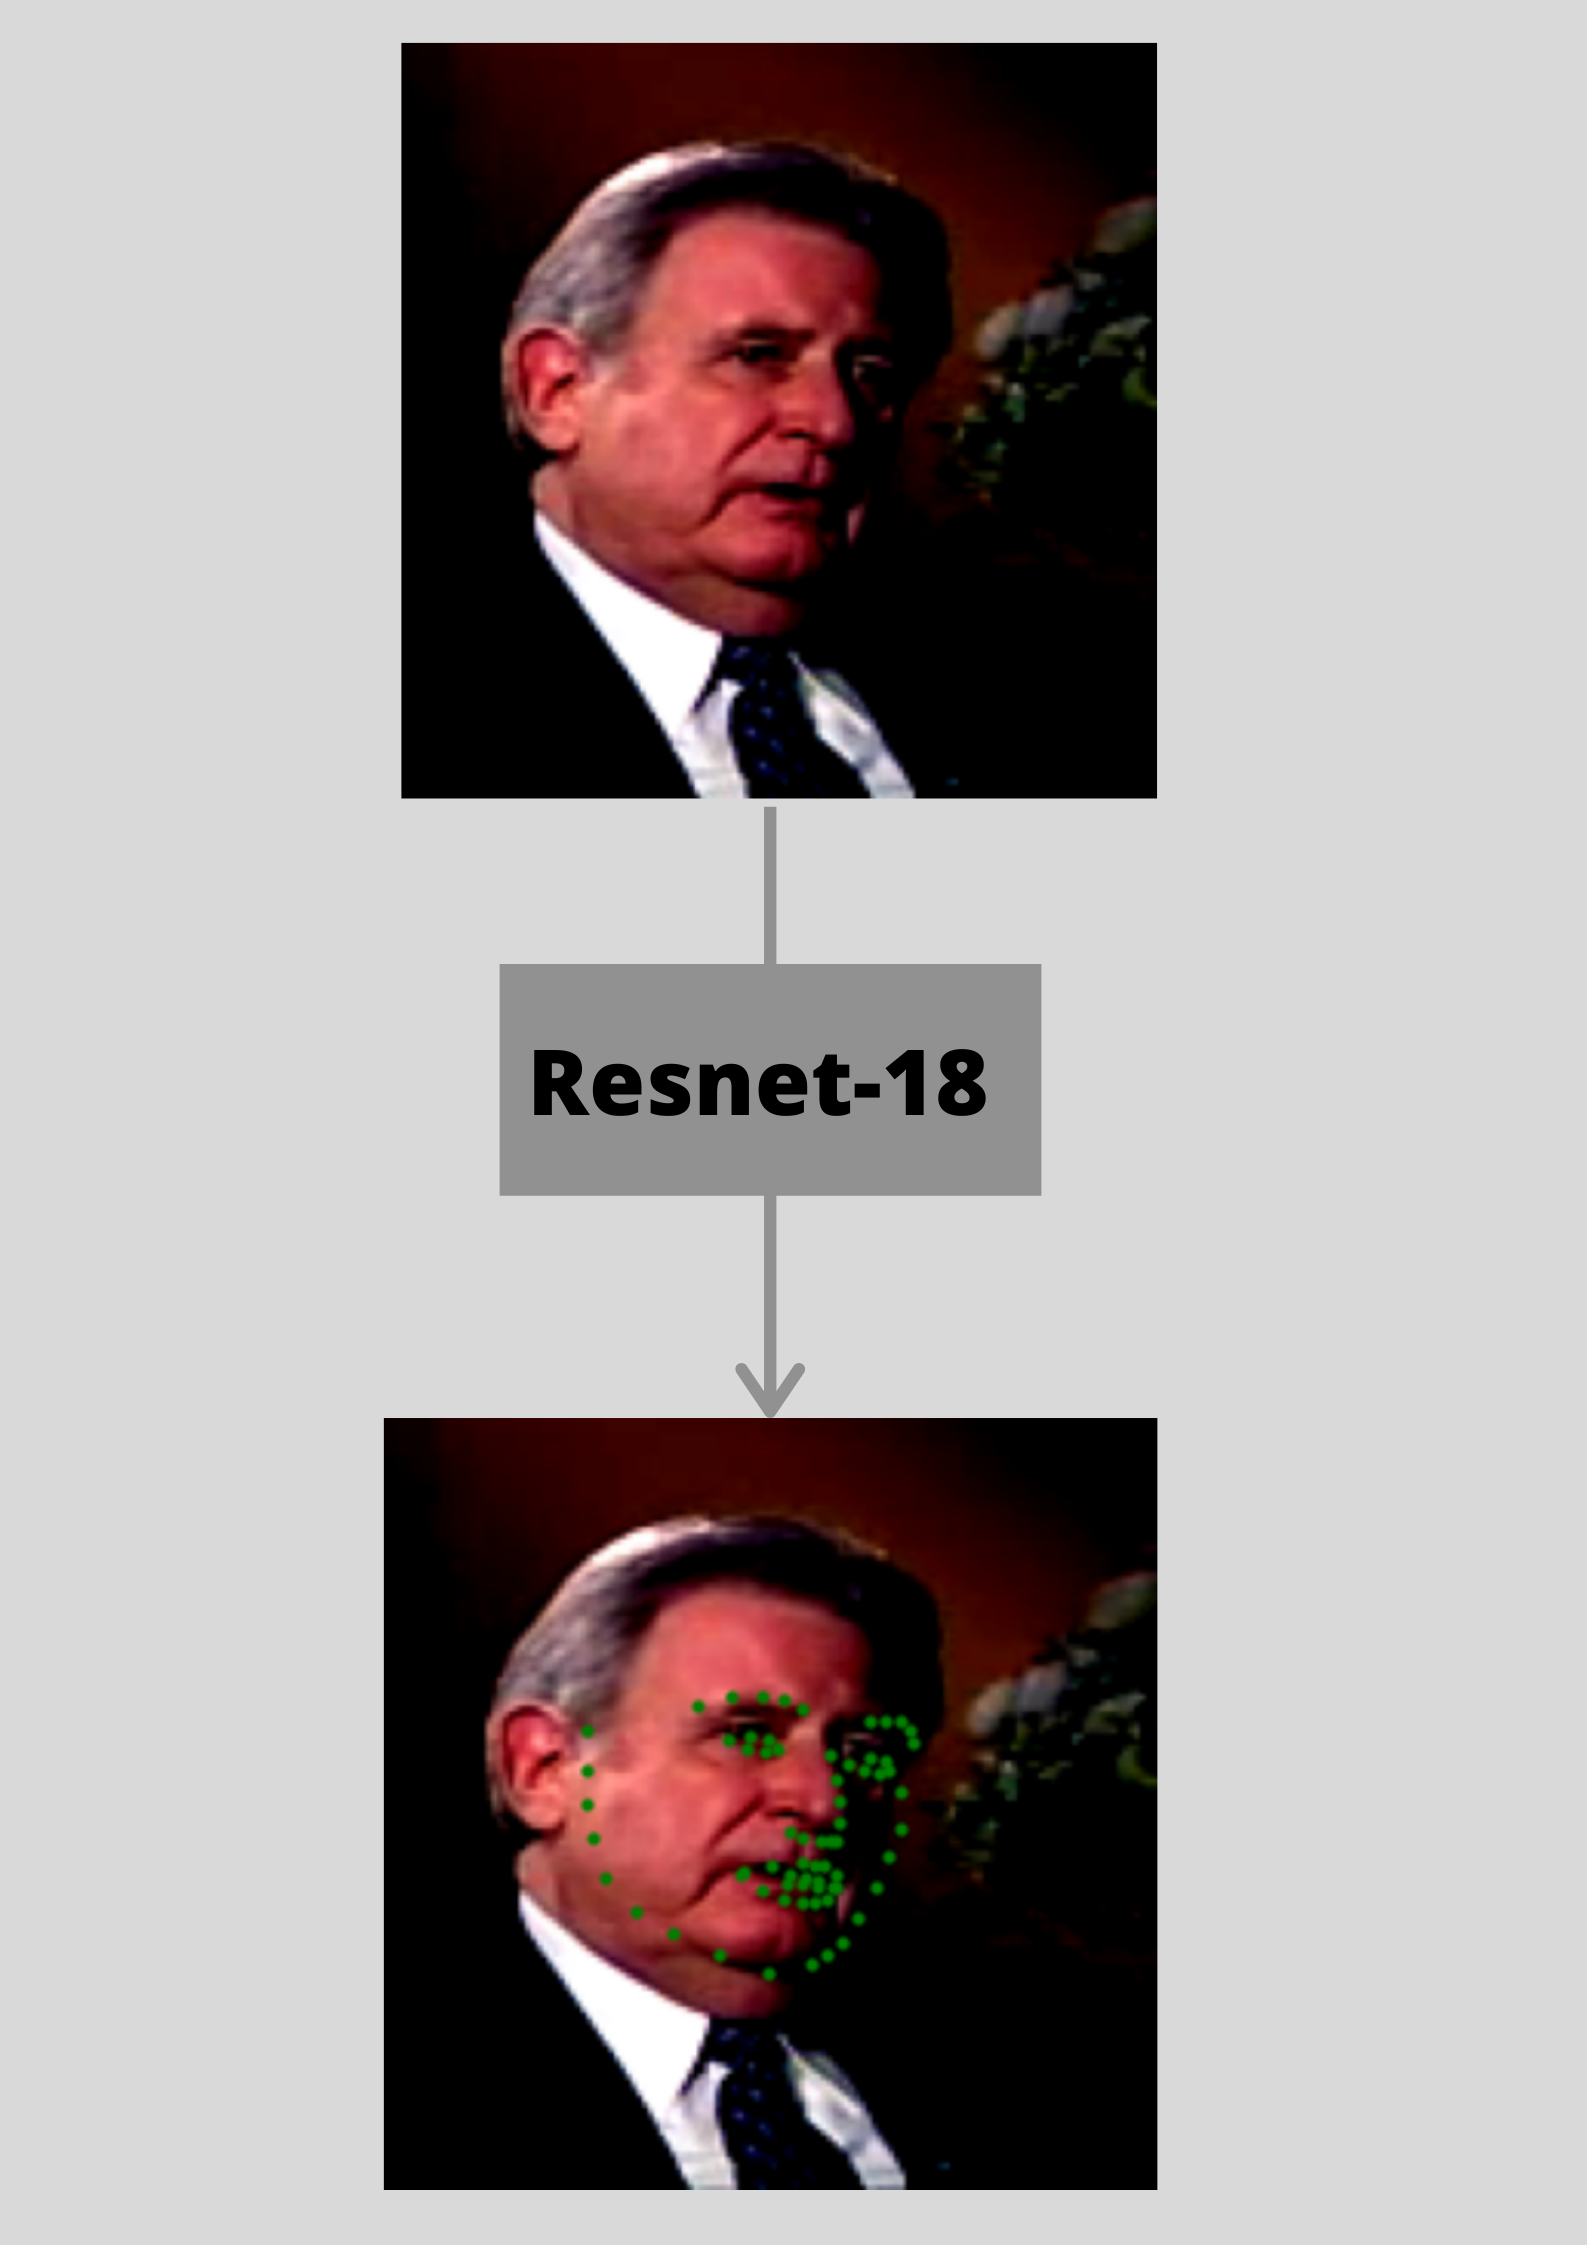

In [5]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel,ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
checkpoint='google/vit-base-patch16-224-in21k'

In [6]:
!unzip -q '/content/drive/MyDrive/data.zip'

# Defining Configuration

In [7]:
main_dir='/content/data/'
training_dir='/content/data/training/'
testing_dir='/content/data/test/'
train_csv='/content/data/training_frames_keypoints.csv'
test_csv='/content/data/test_frames_keypoints.csv'

DEVICE='cuda'
Batch_size=16
IMG_SIZE=224
LR=0.001
EPOCHS=30

# Understanding Facial keypoint Dataset

In [8]:
train_df=pd.read_csv(train_csv)
test_df=pd.read_csv(test_csv)
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [9]:
#Now visualizing the data
idx=5
image_name=train_df['Unnamed: 0'].iloc[idx]
image_path=training_dir+image_name
image=cv2.imread(image_path)
#Now converting the image from bgr to rgb
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#Now keypoint pixel values which are in 136 coloums we will convert them to 68,2
key=train_df.iloc[idx][1:].to_numpy().reshape(-1,2)
print(key)


[[67.0 134.0]
 [69.0 144.0]
 [72.0 154.0]
 [77.0 165.0]
 [79.0 175.0]
 [87.0 185.0]
 [95.0 193.0]
 [105.0 201.0]
 [120.0 201.0]
 [133.0 196.0]
 [138.0 189.0]
 [143.0 181.0]
 [149.0 168.0]
 [151.0 158.0]
 [151.0 148.0]
 [151.0 138.0]
 [149.0 127.0]
 [79.0 131.0]
 [84.0 129.0]
 [92.0 129.0]
 [97.0 129.0]
 [105.0 129.0]
 [123.0 127.0]
 [128.0 127.0]
 [133.0 125.0]
 [138.0 125.0]
 [143.0 125.0]
 [115.0 140.0]
 [115.0 147.0]
 [118.0 155.0]
 [118.0 160.0]
 [110.0 165.0]
 [113.0 165.0]
 [118.0 165.0]
 [120.0 165.0]
 [123.0 163.0]
 [87.0 137.0]
 [92.0 137.0]
 [97.0 137.0]
 [102.0 137.0]
 [97.0 139.0]
 [92.0 139.0]
 [123.0 135.0]
 [128.0 132.0]
 [133.0 132.0]
 [138.0 132.0]
 [133.0 135.0]
 [128.0 137.0]
 [102.0 178.0]
 [108.0 175.0]
 [115.0 173.0]
 [118.0 173.0]
 [123.0 173.0]
 [128.0 173.0]
 [133.0 176.0]
 [128.0 181.0]
 [125.0 183.0]
 [120.0 186.0]
 [115.0 186.0]
 [110.0 181.0]
 [105.0 175.0]
 [115.0 175.0]
 [118.0 176.0]
 [123.0 176.0]
 [131.0 176.0]
 [123.0 178.0]
 [120.0 181.0]
 [115.0 181

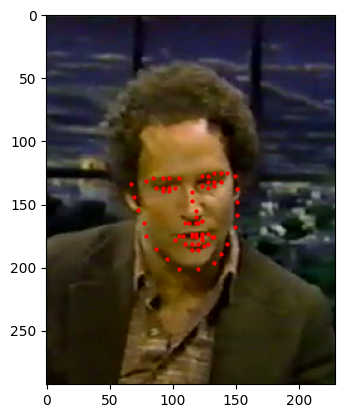

In [10]:
#Now we will visualize
plt.imshow(image)
plt.scatter(key[:,0],key[:,1],s=4,c='r')

# Dividing Training and Test Set

In [11]:
train_df,valid_df=train_test_split(train_df,test_size=0.20,random_state=42)

# Create Custom Facial keypoint Dataset

In [12]:
import albumentations as A
from torch.utils.data import Dataset

In [13]:
#Now importing albumentation library for data augmentation
class FacialKeypointDataset(Dataset):
  def __init__(self,df,img_dir,augmentation=None):
    self.df=df
    self.image_dir=img_dir
    self.augmentation=augmentation

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    image_path=self.image_dir+self.df['Unnamed: 0'].iloc[idx]
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    key=self.df.iloc[idx][1:].to_numpy().reshape(-1,2)

    if self.augmentation:
      augmented_data=self.augmentation(image=image,keypoints=key)
      image=torch.from_numpy(augmented_data['image']).float()
      key=torch.tensor(augmented_data['keypoints']).float()

    #Now time to return
    return image.permute(2,0,1),key.view(-1) #flattens the tensor

In [14]:
#Now writing augementations for training and test data
train_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.Normalize(),
        #A.HorizontalFlip(p=0.5)a
    ]
,keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
)

In [15]:
valid_augs=A.Compose(
    [
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.Normalize()
    ],
    keypoint_params=A.KeypointParams(format='xy',remove_invisible=False)
)

In [16]:
trainset=FacialKeypointDataset(train_df,training_dir,train_augs)
validset=FacialKeypointDataset(valid_df,training_dir,valid_augs)
testset=FacialKeypointDataset(test_df,testing_dir,valid_augs)

In [17]:
print("Total no. of examples present in trainset : {}".format(len(trainset)))
print("Total no. of examples present in validset : {}".format(len(validset)))

Total no. of examples present in trainset : 2769
Total no. of examples present in validset : 693


In [18]:
import numpy as np
def show_with_key(image,key):
  #Now convert tensor to numpy array
  image=image.permute(1,2,0).cpu().detach().numpy()
  key=key.view(-1,2).cpu().detach().numpy()

  image=image*np.array([0.485,0.456,0.406])+np.array([0.229,0.224,0.225])

  plt.imshow(image)
  plt.scatter(key[:,0],key[:,1],s=10,c='r')

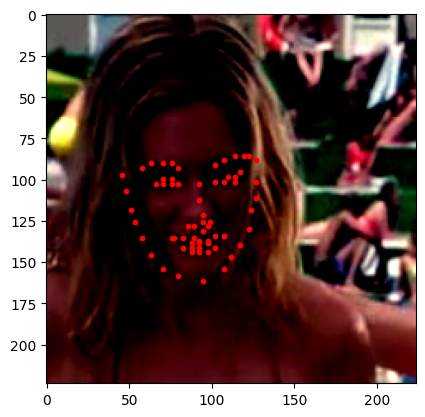

In [19]:
img,key=trainset[56]
show_with_key(img,key)

# Load Dataset Into Batches

In [20]:
#Now we will write dataloader
trainloader=torch.utils.data.DataLoader(trainset,batch_size=Batch_size,shuffle=True)
validloader=torch.utils.data.DataLoader(validset,batch_size=Batch_size,shuffle=False)

In [21]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 174
Total no. batches in validloader : 44


In [22]:
for data in trainloader:
  img,key=data
  break
print("Image size: ",img.shape)
print("Keyset size: ",key.shape)

Image size:  torch.Size([16, 3, 224, 224])
Keyset size:  torch.Size([16, 136])


# Creating Model

In [23]:
class ViT(nn.Module):
  def __init__(self,config=ViTConfig(),num_classes=136,model_ckpt=checkpoint):
    super(ViT,self).__init__()
    self.vit=ViTModel.from_pretrained(model_ckpt,add_pooling_layer=False)
    print("Transformer Load Complete")
    self.classifier=(
        nn.Linear(config.hidden_size,num_classes)
    )

  def forward(self,image,keys=None):
    x=self.vit(image)['last_hidden_state']
    #use the embedding of cls token
    output=self.classifier(x[:,0,:])
    if keys!=None:
      return output,nn.MSELoss()(output,keys)
    return output

In [24]:
model=ViT()
model.to(DEVICE);

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Transformer Load Complete


In [25]:
model(torch.randn(16,3,224,224).to('cuda')).shape

torch.Size([16, 136])

In [26]:
from pyparsing import rest_of_line
def train_function(model,trainloader,optimizer):
  train_loss=0.0
  model.train()
  for data in tqdm(trainloader):
    images,keys=data

    images=images.to(DEVICE)
    keys=keys.to(DEVICE)

    logits,loss=model(images,keys)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  return train_loss/len(trainloader.dataset)

In [27]:
def valid_function(model,validloader):
  valid_loss=0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(validloader):
      images,keys=data
      images=images.to(DEVICE)
      keys=keys.to(DEVICE)

      logits,loss=model(images,keys)
      valid_loss+=loss.item()

    return valid_loss/len(validloader.dataset)

In [28]:
optimizer=torch.optim.Adam(params=model.parameters(),lr=LR)
best_valid_loss=np.Inf
for epoch in range(10):
  train_loss=train_function(model,trainloader,optimizer)
  valid_loss=valid_function(model,validloader)
  if valid_loss<best_valid_loss:
    print("Model is saved")
    torch.save(model.state_dict(),"FaceModel.pt")
    best_valid_loss=valid_loss
  print(f"{epoch}/{10} training loss {train_loss} validation loss {valid_loss}")

100%|██████████| 44/44 [00:10<00:00,  4.24it/s]


Model is saved
0/10 training loss 494.6602267413072 validation loss 82.78327587397412


100%|██████████| 44/44 [00:10<00:00,  4.32it/s]


Model is saved
1/10 training loss 21.209510894147186 validation loss 9.69375600443258


100%|██████████| 44/44 [00:10<00:00,  4.17it/s]


Model is saved
2/10 training loss 9.590376584268986 validation loss 9.512198554144966


100%|██████████| 44/44 [00:10<00:00,  4.12it/s]


Model is saved
3/10 training loss 9.617122855415495 validation loss 9.496916656714324


100%|██████████| 44/44 [00:09<00:00,  4.45it/s]


Model is saved
4/10 training loss 9.58283959936691 validation loss 9.492476194967955


100%|██████████| 44/44 [00:10<00:00,  4.35it/s]


5/10 training loss 9.591268562159843 validation loss 9.535378328133454


100%|██████████| 44/44 [00:10<00:00,  4.32it/s]


6/10 training loss 9.673915682565697 validation loss 9.525809129767259


100%|██████████| 44/44 [00:10<00:00,  4.24it/s]


7/10 training loss 9.609845347075568 validation loss 9.511383684166582


100%|██████████| 44/44 [00:10<00:00,  4.25it/s]


8/10 training loss 9.578360983592674 validation loss 9.499035393520867


100%|██████████| 44/44 [00:10<00:00,  4.25it/s]


Model is saved
9/10 training loss 9.58785643462198 validation loss 9.481214118726326


100%|██████████| 44/44 [00:10<00:00,  4.30it/s]


10/10 training loss 9.585303716084379 validation loss 9.498224013467544


100%|██████████| 44/44 [00:10<00:00,  4.31it/s]


11/10 training loss 9.620796840084981 validation loss 9.485330600931187


100%|██████████| 44/44 [00:10<00:00,  4.39it/s]


12/10 training loss 9.865835554206273 validation loss 9.553311985120457


100%|██████████| 44/44 [00:09<00:00,  4.41it/s]


13/10 training loss 9.603152293339237 validation loss 9.496381046796087


100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


14/10 training loss 9.60966828946561 validation loss 9.509497836554722


100%|██████████| 44/44 [00:09<00:00,  4.40it/s]


15/10 training loss 9.66021645305905 validation loss 9.551305047017328


100%|██████████| 44/44 [00:10<00:00,  4.33it/s]


16/10 training loss 9.618018726529348 validation loss 9.531155353672748


100%|██████████| 44/44 [00:10<00:00,  4.25it/s]


17/10 training loss 9.570813364653693 validation loss 9.580709250974449


100%|██████████| 44/44 [00:10<00:00,  4.25it/s]


18/10 training loss 9.580103360689604 validation loss 9.710599197453751


100%|██████████| 44/44 [00:10<00:00,  4.24it/s]


Model is saved
19/10 training loss 9.59497833527482 validation loss 9.476948109196034


In [29]:
def compare_keypoints(image, key, out_key):
	image = image.squeeze().permute(1,2,0)
	image = image.cpu().detach().numpy()
	image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])

	f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

	ax1.set_title('original-keypoints')
	ax1.imshow(image)
	key = key.view(-1,2).cpu().detach().numpy()
	ax1.scatter(key[:,0],key[:,1], s = 10, c = 'b')

	ax2.set_title('model-keypoints')
	ax2.imshow(image)
	out_key = out_key.view(-1,2).cpu().detach().numpy()
	ax2.scatter(out_key[:,0],out_key[:,1], s = 10, c = 'g')


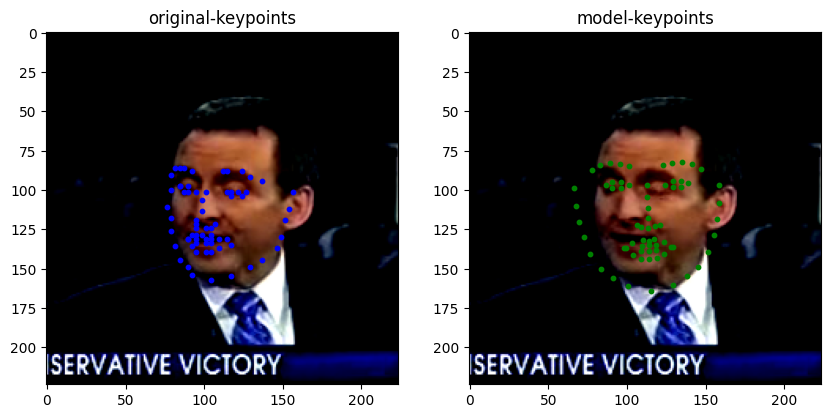

In [30]:
import helper
index=9
image,key=testset[index]
model.load_state_dict(torch.load('FaceModel.pt',map_location=DEVICE))
model.eval()
with torch.no_grad():
  image=image.to(DEVICE)
  out_key=model(image.unsqueeze(0))
  compare_keypoints(image,key,out_key)